## Vital Elements of Calculus Series

# Part 4: Automatic Differentiation

In the previous post we detailed how we can derive derivative formulae for any function constructed from elementary functions and operations, and how derivatives of such functions are themselves constructed from elementary functions/operations.  These facts have far-reaching consequences for the practical computing of derivatives - allowing us to construct a very effective derivative calculator called *Automatic Differentiaton* which we detail here.

More specifically we describe how one can quickly code up the so-called *forward mode* of Automatic Differentiation, a natural and direct implementation of the method for calculating derivatives 'by hand' using a computation graph as discussed in the previous post.  Leveraging closed form derivative rules - instead of e.g., numerical approximation - the Automatic Differentiator it is typically more accurate than the Numerical Differentiatiion calculator discussed in the second post of this series, and has no parameters that require tuning.

In [4]:
# imports from custom library
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from mlrefined_libraries import calculus_library as calclib
from mlrefined_libraries import basics_library as baslib

In [5]:
%load_ext autoreload
%autoreload 2

# 1.  Basic design elements of the Automatic Differentiator

In this Section we outline the basic design elements of an Automatic Differentiation (AD) calculator, which largely involves discussing how to organize and implement the derivative rules described in the previous post.  In addition we also describe a simple way to significantly improve the usability of the AD calculator via *operator overloading*.

## 1.1  Keep track of function and derivative evaluations at a point

In the previous post we described an algorithmic process - based on the elementary function/operation derivative rules - to derive an *algebraic function* for the derivative of an input function.  While the AD calculator employs these rules in precisely the same manner it produces a *programatic function* of the derivative, i.e., a subroutine that provides mathematically correct evaluations of the mathematical function and its derivative for any input desired.  In other words, the fundamental object on which the AD calculator operates on is a tuple of values consisting of the evaluation of the function and its derivative at a point [[1]](#endnotes).

> The AD calculator employs derivative rules in precisely the same manner as we applied by hand but produces a *programatic function* of the derivative, i.e., a subroutine that provides correct evaluation of the mathematical function and its derivative for any input desired.  In other words, the fundamental object on which the AD calculator operates on is a tuple of values consisting of the evaluation of the function and its derivative at a point.

As we further develop the AD calculator we will see that a very convenient way to store, transport, and update these two values is by incorporating them into a simple Python class-object.

We define this simple class below - again instances of this class are simply a convenient way of holding onto the current evaluation of a function (called *val* for short) as well as its derivative value (called *der*). For those wanting a good introduction to Python classes in the context of mathematical functions see e.g., [this excellent book](http://hplgit.github.io/primer.html/doc/pub/class/class-readable.html).

In [6]:
class MyTuple:
    '''
    The basic object manipulated by an AD calculator
    Instances of this class is a tuple containining one 
    function/derivative evaluation.
    '''
    def __init__(self,**kwargs):
        # variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1    
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']

## 1.2  Creating derivative rules for elementary functions

With our base object taken care of we can quickly code up the derivative rules for elementary functions contained in Table 1 of the previous post, which we repeat here for convenience.

<br>
  <center>
  <caption>Table 1: Derivative formulae for elementary functions</caption>
  </center>
  
<table>
  <col width="160">
  <col width="100">
  <col width="100">

<thead>
<tr>
    <th>elementary function</th>
    <th>equation</th> 
    <th>derivative</th>
  </tr>
  </thead>
  <tbody>
    <tr>
    <td>constant</td>
    <td>$c$</td>
    <td>$0$</td>

  </tr>
  <tr>
    <td>monomial (degree $p\neq 0$)</td>
    <td>$w^p$</td>
    <td>$pw^{p-1}$</td>

  </tr>
    <tr>
    <td>sine</td>
    <td>$\text{sin}(w)$</td>
    <td>$\text{cos}(w)$</td>

  </tr>
  <tr>
    <td>cosine</td>
    <td>$\text{cos}(w)$</td>
    <td>$-\text{cos}(w)$</td>

  </tr>
  <tr>
    <td>exponential</td>
    <td>$e^w$</td>
    <td>$e^w$</td>

  </tr>
  <tr>
    <td>logarithm</td>
    <td>$\text{log}(w)$</td>
    <td>$\frac{1}{w}$</td>

  </tr>
    <tr>
    <td>hyperbloic tangent</td>
    <td>$\text{tanh}(w)$</td>
    <td>$1 - \text{tanh}^2(w)$</td>

  </tr>
      <tr>
    <td>rectified linear unit (ReLU) </td>
    <td>$\text{max}\left(0,x\right)$</td>
    <td>$\begin{cases}
0 & w\leq0\\
1 & w>0
\end{cases}$</td>
  </tr>
  </tbody>
</table>
</br>

Since we are tracing both the function and derivative evaluation in order to create one of these rules as a Python function we need to define how the elementary function transforms the input function value, as well as how its corresponding derivative rule transforms the input derivative value. 

We walk through several examples below.

#### <span style="color:#a50e3e;">Example. </span> Computing the derivative of $g(w) = \text{sin}(w)$

For example, we have a Python function for the sinusoid update rule in the next cell.

In [7]:
# our implementation of the sinusoid rule from Table 1
def sin(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.sin(a.val)

    # Produce new derivative value
    b.der = np.cos(a.val)*a.der
    
    # Return updated object
    return b

Here we input $a$, an ```MyTuple``` object with a current function and derivative value, and create a new instance to contain their updates called $b$.  To get the new function update

```
b.val = np.sin(a.val)
```

we simply pass the current value through a sinusoid.  The corresponding derivative value update 

```
b.der = np.cos(a.val)*a.der
```

involves two parts.  The sinusoid derivative rule alone would have us update the derivative value by simply passing ```a.val``` through cosine.  But remember - as discussed in the previous post - that every time we apply an elementary derivative formula we must apply the *chain rule* as well.  This is why we multiply ```np.cos(a.val)``` by ```a.der``` in the update.

We can now test our sinusoid function over a few input points, as is done in the next cell.  

In [8]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w)

# initialize our AutoDiff object at each point
a1 = MyTuple(val = 0); a2 = MyTuple(val = 0.5)

# evaluate
result1 = g(a1); result2 = g(a2)

# print results
print ('function value at ' + str(0) + ' = ' + str(result1.val))
print ('derivaive value at ' + str(0) + ' = ' + str(result1.der))

print ('function value at ' + str(0.5) + ' = ' + str(result2.val))
print ('derivaive value at ' + str(0.5) + ' = ' + str(result2.der))

function value at 0 = 0.0
derivaive value at 0 = 1.0
function value at 0.5 = 0.479425538604
derivaive value at 0.5 = 0.87758256189


This looks fine - so lets evaluate over a large range of inputs and visualize both the function and derivative values.  In the next Python cell we use a short custom plotting function that performs the above evaluations over a large range of input values, and then plots the resulting function/derivative values.

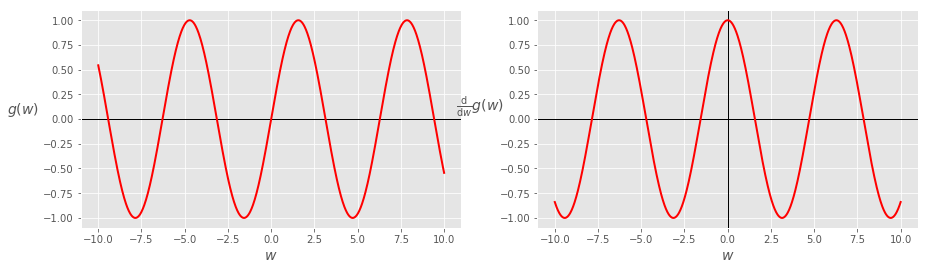

In [24]:
# define a function using our AD components
g = lambda w: sin(w)

# use custom plotter to evaluate over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

And indeed this is correct: the function evaluation is sine and the derivative evaluation is cosine over the entire input range.

#### <span style="color:#a50e3e;">Example. </span> Computing the derivative of $g(w) = w^n$

We can define a power rule precisely as done with the sinusoid function in the previous example: updating the current function evaluation using the elementary function, and the current derivative value using the corresponding derivative rule from Table 1.  Once again we must include an instance of the chain rule with our derivative update.

In [25]:
# our implementation of the power rule from Table 1 
def power(a,n):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = a.val**n

    # Produce new derivative value
    b.der = n*(a.val**(n-1))*a.der
    
    # Return updated object
    return b

And we can test out this function by evaluating/plotting over a large range of inputs, say the third degree monomial $w^2$.

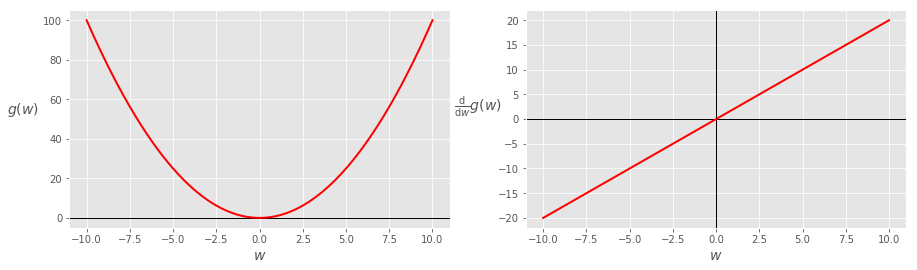

In [26]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: power(w,2)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Again everything looks good.

#### <span style="color:#a50e3e;">Example. </span> Computing the derivative of $g(w) = \text{tanh}(w)$

As with the previous examples we can define the $\text{tanh}$ function, making sure to include the chain rule with our update of the derivative value.

In [13]:
# our implementation of the power rule from Table 1 
def tanh(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.tanh(a.val)

    # Produce new derivative value
    b.der = (1 - np.tanh(a.val)**2)*a.der
    
    # Return updated object
    return b

And we can test our new tanh function over a range of values.

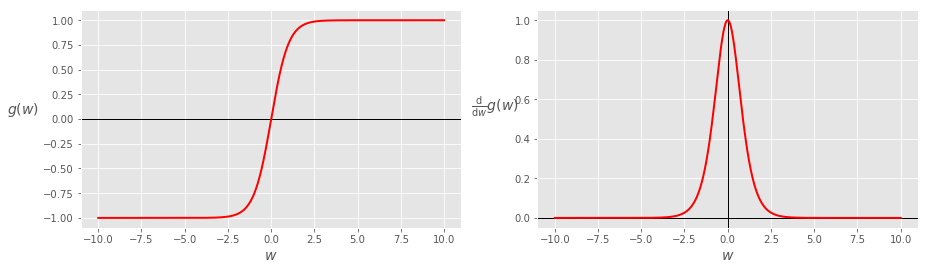

In [27]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

This is correct!  We can of course verify that this is correct by plotting the function and derivative equations given in the table.  We do this in the next cell using a custom plotting function.

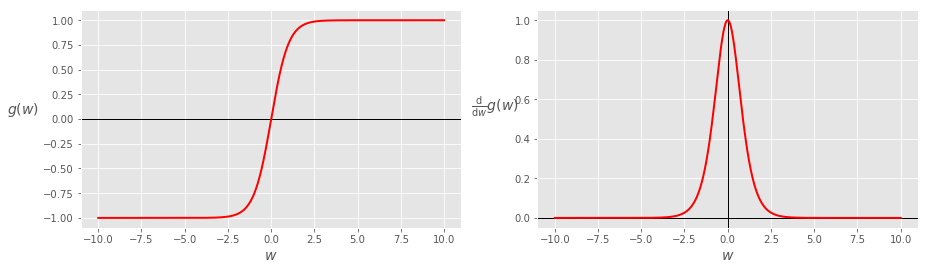

In [29]:
# define function and its derivative equations using numpy
g = lambda w: np.tanh(w)
dgdw = lambda w: (1 - np.tanh(w)**2)

# plot both
calclib.plotter.derval_eq_plot(g,dgdw)

---

We can very easily continue, defining a function for each elementary derivative rule precisely as we have done here with these three examples.  The only wrinkle to remember with each is that we must include an instance of the chain rule with each derivative update from Table 1. 

## 1.3 Creating derivative rules for elementary operations

In the previous post we described derivative rules for each elementary operation, which we repeat below for convenience. 

<br>
  <center>
  <caption>Table 2: Derivative formulae for elementary operations</caption>
  </center>
<table>
  <col width="800">
  <col width="300">
  <col width="600">
<thead>
<tr>
    <th>operation</th> 
    <th>equation</th>
    <th>derivative rule</th> 
   
  </tr>
  </thead>
  <tbody>
     <tr>
    <td> addition of a constant $c$ </td>
    <td> $g(w) + c$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(g(w) + c\right)=  \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
  
    <tr>
    <td> multiplication by a constant $c$ </td>
    <td> $cg(w)$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(cg(w)\right)=  c\frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
  
  <tr>
  <td> addition of functions (often called the *summation rule*)</td>
    <td> $f(w) + g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w) + g(w))=  \frac{\mathrm{d}}{\mathrm{d}w}f(w) + \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
  <tr>
  <td> multiplication of functions (often called the *product rule*) </td>
    <td> $f(w)g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w)\cdot g(w))=  \left(\frac{\mathrm{d}}{\mathrm{d}w}f(w)\right)\cdot g(w) + f(w)\cdot \left(\frac{\mathrm{d}}{\mathrm{d}w}g(w)\right)$
    </td>
  </tr>

  <tr>
  <td> composition of functions (often called the *chain rule*)</td>
    <td> $f(g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(g(w)))= \frac{\mathrm{d}}{\mathrm{d}g}f(g) \cdot \frac{\mathrm{d}}{\mathrm{d}w}g(w)$
  </td>
  </tr>
  
  <tr>
  <td> maximum of two functions </td>
    <td> $\text{max}(f(w),\,g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(\text{max}(f(w),\,g(w))) = \begin{cases}
\frac{\mathrm{d}}{\mathrm{d}w}f\left(w\right) & \text{if}\,\,\,f\left(w\right)\geq g\left(w\right)\\
\frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) & \text{if}\,\,\,f\left(w\right)<g\left(w\right)
\end{cases}$
  </td>
  </tr>
  
  </tbody>
</table>

As with the derivative formulae for elementary functions, implementing these rules means providing - in each case - an update for the function and derivative value.  We walk through several examples below.

#### <span style="color:#a50e3e;">Example. </span> Coding up the addition rules

In addition to making sure we update function and derivative values, when coding up the addition rules we may as well knock out both of the addition rules in Table 2: defining the derivative of a function and constant, and two functions.  A simple switch or if/else statement is used below to sort between these two cases.

In [15]:
# our implementation of the addition rules from Table 2
def add(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a + b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val + b
        c.der = a.der
    else: # both inputs are MyTuple objects
        c.val = a.val + b.val
        c.der = a.der + b.der
    
    # Return updated object
    return c

With the addition rules taken care of above we can try it out using two of the elementary function rules coded in the previous subsection.  In particular we test with the sum 

$$
\text{sin}(w) + w
$$

since both the sinusoid and the power function update rules were coded previously.

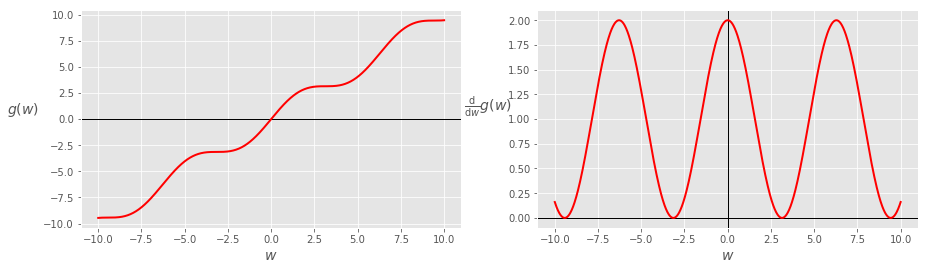

In [16]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: add(sin(w),power(w,1))

# use the custom plotting function above to plot over a large range of inputs
plot_val_der(g)

#### <span style="color:#a50e3e;">Example. </span> Coding up the multiplication rules

Since we also have several multiplication rules - what to do with the product of a constant and a function, and two functions - we can also  wrap both rules up into one Python function, using a switch or if/else to distinguish between them.

In [48]:
# our implementation of the addition rules from Table 2
def multiply(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a*b.val
        c.der = a*b.der
    elif type(b) != MyTuple:
        c.val = a.val*b
        c.der = a.der*b
    else: # both inputs are MyTuple objects
        c.val = a.val*b.val
        c.der = a.der*b.val + a.val*b.der     # product rule
    
    # Return updated object
    return c

With the multiplication rules taken care of above we can try it out using two of the elementary function rules coded in the previous subsection.  In particular we test with the sum 

$$
\text{sin}(w)\times w
$$

since both the sinusoid and the power function update rules were coded previously.

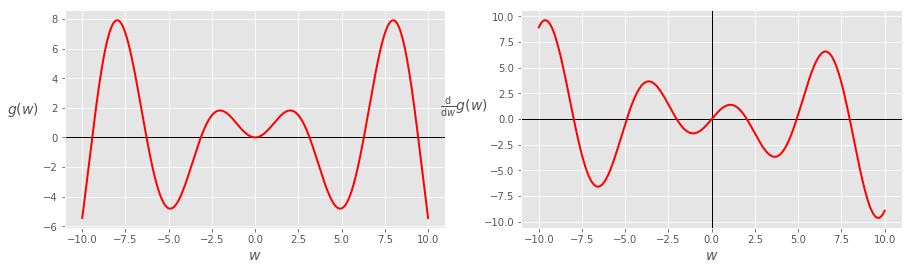

In [66]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: multiply(sin(w),power(w,1))

# use the custom plotting function above to plot over a large range of inputs
plot_val_der(g)

Its easy to check that this is correct by plotting the derivative equation itself, which using the elementary function/operation rules can be written as

$$
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = \text{sin}(w) + \text{cos}(w)w
$$

We plot this equation directly, along with the original function, in the next Python cell.

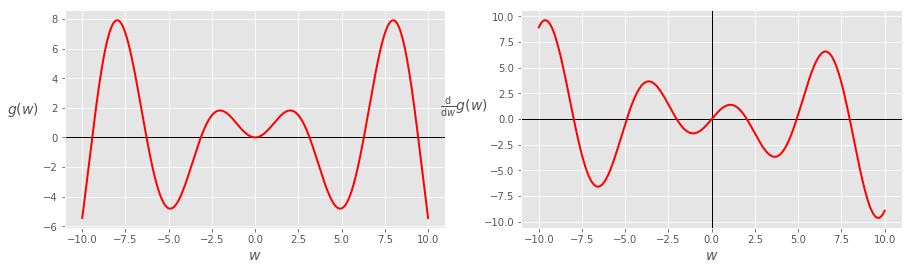

In [68]:
# define function and its derivative equations
g = lambda w: np.sin(w)*w
dgdw = lambda w: np.sin(w) + np.cos(w)*w

# plot both
calclib.plotter.derval_eq_plot(g,dgdw)

## 1.4  Improving usability via operator overloading

With our current AD calculator setup we have just seen that in order to compute the derivative of 

$$
g(w) = \text{sin}(w) + w
$$

we use the somewhat clunky Python notation

```
add(sin(w),power(w,1))
```

to invoke summation and power derivative rules, and compute the derivative of the function.  In this subsection we briefly discuss how one can use *operator overloading* to assign functions like ```add``` and ```power``` to more natural Python symbols, making the above look more similar to the algebraic form of the input function

```
sin(w) + w
```

# 1.5  How to parse the graph / information flow

The computation graph is a powerful tool for recursively describing how a mathematical function is constructed, how it is evaluated, and how its derivative is formed.  In particular we have seen how *recursively sweeping forward through a computation graph* breaks down these calculations into a sequence of small calculations. 


IMAGE OF CALCULATIONS FLOWING FORWARD ON A COMPUTATION GRAPH

When performing these calculations by hand our main concerns become the redundancy of performing these small calculation by hand, and the logistical nightmare that can arise in keeping them all organized for more complex functions.  Thankfully because recursive algorithms are so naturally dealt with using programatic for loops / while loops, the computation graph provides a bridge for thinking about how to perform / organize computations involving mathematical functions - like e.g., derivative calculations - on a computer instead of by hand.

It looks like indeed our AD calculator computes the derivative perfectly for this example.

As with the power rule - as detailed in the first example - we can overload the addition '+' and multiplication '\*' Pythonic operators so that Python understands how these standard operators apply to our AutoDiff objects.

```f*g``` $\longrightarrow$ ```product(f,g)```

```f+g``` $\longrightarrow$ ```add(f,g)```

We make these assignments in the next Python cell.

In [94]:
# overload the addition operator for our AutoDiff objects
AD.__add__ = add

# overload the product operator for our AutoDiff objects
AD.__mul__ = product

Finally, with cosine and the summation / product rules defined we can compute the derivative of 

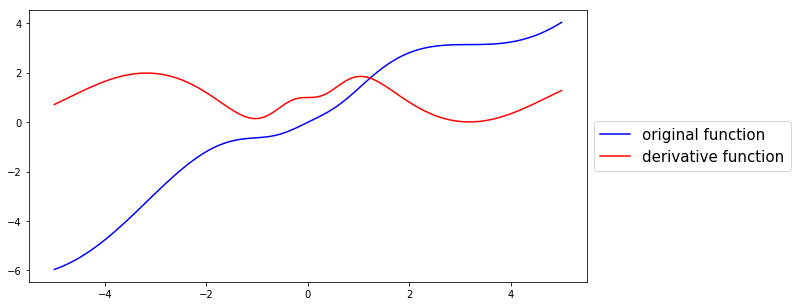

In [97]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: sin(w)*tanh(w)**3 + w
wvals = np.linspace(-5,5,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

### Summary and further steps

To further develop this AD calculator we can continue to code up formulae / rules from Tables 1 and 2 in a completely similar manner to what we have seen with the examples here. 

## 2.3  The only difference between theory and practice

The only difference between theory and practice is this: the computation graph of a function is more effecient than the function itself to a computer.  Take an example like 

$$
g(w) = \frac{\text{sin}(w^2)}{w^2}
$$

versus its computation graph which we can list as the sequence of the following two equations

\begin{array}
\
a = w^2 \\
b = \text{sin}(a) \\
c = \frac{b}{a} \\
\end{array}

Although both represent the same relationship, evaluating the full function (and its derivative) is more costly than evaluating the computation graph because $w^2$ is constructed twice in the full version.

<a id='endnotes'></a>
## Endnotes

[1]  That the AD does not provide an algebraic description of the derivative function is a mute point for applications in machine learning / deep learning - as the programatic form is entirely equivalent to the algebraic equation and what we want is not to produce equations, but a way to automate precise derivative calculations 

One can build an algorithm that employs the basic derivative rules to provides an algebraic derivative, but this requires the implementation of a [computer algebra system](https://en.wikipedia.org/wiki/Computer_algebra_system).  Such a derivative calculator - that deals with derivatives using symbolic computation (i.e., algebra on the computer) - is called a *Symbolic Differentiator*.  However there are a few reasons why - at least for machine learning / deep learning applications - why *Automatic Differentiation* is a better choice.  

First off for our applications we only need a calculator that can provide a programatic description for the derivative - i.e., one that provides precise derivative value at selected input points - which the AD calculator provides.  

Secondly the AD calculator requires fewer tools to build, as it requires only basic coding methods and no computer algebra systems.

Thirdly expressing derivative equations algebraically can be quite unweildly.  For example, the rather complicated looking function

\begin{equation}
g(w) = \text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\text{log}\left(\frac{1}{w^2 + 1} \right)\frac{w^2 + 1}{\text{cos}(\text{sin}(w))}
\end{equation}

has an expansive algebraic derivative.   Below are just the first few terms 

$$
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = -2w\,\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right) \, \frac{1}{\text{cos}(\text{sin}(w))} + 2w\,\text{log}\left(\frac{1}{w^2 + 1}\right)\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\frac{1}{\text{cos}(\text{sin}(w))} + \cdots
$$

And this sort of problem is exponentially worse - to the point of being a considerable computational burden - when dealing with multivariable functions.  Such an example illustrates the real need to automatic *simplifying* of algebraic expressions as well, ideally during the differentiation process to make sure things do not get too far out of hand.  AD  - while not algebraic method - essentially does this simpfliciation automatically actively while computing derivatives. 

<blockquote style="border-left: 5px solid; border-left-color: #ccc; background: white;"><p>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit <a href="http://mlrefined.com">http://mlrefined.com</a> for free chapter downloads and tutorials, and <a href="https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&amp;qid=1474491657&amp;sr=8-1&amp;keywords=machine+learning+refined">our Amazon site</a> for details regarding a hard copy of the text.</p>
</blockquote>